In [2]:
import torch
import torch.nn.functional as F
from torch import nn
import torch.utils.data as data_utils
from tqdm import tqdm
import matplotlib.pyplot as plt

## Basic Self Attention

Calculating the raw weights

In [ ]:
# assume we have tensor x with dimensions (b, t, k)
x = ...

raw_weights = torch.bmm(x ,x.transpose(1,2)) # x.T((1,2)) -> (b, k, t)
# bmm means that for each sample in batch: x * x.T (t,k)*(k,t) = (t,t)
# torch bmm is batched matrix multiplication. Applying matrix multiplication over batches of matrices

Applying softmax to normalize the weights

In [ ]:
weights = F.softmax(raw_weights, dim=2)

Weighted linear combination of input vectors to get output vectors

In [ ]:
y = torch.bmm(weights, X)

## Complete Self Attention
This cell contains the code for a single multi-headed attention block

In [6]:
class SelfAttention(nn.Module):
    def __init__(self, k, heads=4, mask=False):
        super().__init__()
        assert k % heads == 0
        self.k, self.heads = k, heads

        self.toKeys = nn.Linear(k, k, bias=False)
        self.toQueries = nn.Linear(k,k, bias=False)
        self.toValues = nn.Linear(k,k, bias=False)

        self.unifyHeads = nn.Linear(k, k)

    def forward(self, x):
        b, t, k = x.size()

        h = self.heads

        queries = self.toQueries(x)
        keys    = self.toKeys(x)
        values  = self.toValues(x)

        s = k // h
        
        keys = keys.view((b, t, h, s))
        values = values.view((b, t, h, s))
        queries = queries.view((b, t, h, s))

        # - fold heads into the batch dimension
        keys = keys.transpose(1, 2).contiguous().view(b * h, t, s)
        queries = queries.transpose(1, 2).contiguous().view(b * h, t, s)
        values = values.transpose(1, 2).contiguous().view(b * h, t, s)

        # get dot product of queries and keys and scale
        dot = torch.bmm(queries, keys.transpose(1,2))
        # scale the dot
        dot = dot / (k ** 0.5)
        # dont forget the softmax
        dot = F.softmax(dot, dim=2)
        # apply self attn
        out = torch.bmm(dot, values).view (b, h, t, s)

        # swap h, t back, unify heads
        out = out.transpose(1, 2).contiguous().view(b, t, h * s)
        
        return self.unifyHeads(out)
    

## Transformer Architecture
A transformer is not a self-attention layer, just like a CNN is not a single convolution. Roughly stated, it's a an architecture processing tokens in a sequence and their interactions using self attention.

In [7]:
class TransformerBlock(nn.Module): # emulates the TransformerEncoderLayer
    def __init__(self, k, heads):
        super().__init__()

        self.attention = SelfAttention(k, heads=heads)

        self.norm1 = nn.LayerNorm(k)
        self.norm2 = nn.LayerNorm(k)

        self.ff = nn.Sequential(
            nn.Linear(k, 4 * k),
            nn.ReLU(),
            nn.Linear(4 * k, k),
        )

    def forward(self, x):
        attended = self.attention(x)
        x = self.norm1(attended + x)
        
        fedforward = self.ff(x)
        return self.norm2(fedforward + x)

## Classification Transformer

In [8]:
class Transformer(nn.Module):
    def __init__(self, k, heads, depth, seq_length, num_tokens, num_classes):
        # k is emulated by d_model
        # ntoken is num_tokens
        # nhead is heads
        # nlayers is depth
        # d
        super().__init__()

        self.num_tokens = num_tokens
        self.token_emb = nn.Embedding(num_tokens, k) # will perform embedding for num_tokens unique inputs into dimension k
        self.pos_emb = nn.Embedding(seq_length, k)

        tblocks = [] # emulates the TransformerEncoder
        for i in range(depth): # depth specifies number of transformer blocks
            tblocks.append(TransformerBlock(k=k, heads=heads))
        self.tblocks = nn.Sequential(*tblocks)

        self.toprobs = nn.Linear(k, num_classes)

    def forward(self, x):
        """
        :param x: A (b, t) tensor of integer values representing
                  words (in some predetermined vocabulary).
        :return: A (b, c) tensor of log-probabilities over the
                 classes (where c is the nr. of classes).
        """
        tokens = self.token_emb(x)
        b, t, k = tokens.size()

        positions = torch.arange(t)
        positions = self.pos_emb(positions)[None, :, :].expand(b, t, k)

        x = tokens + positions
        x = self.tblocks(x)
        x = self.toprobs(x.mean(axis=1))        
        return F.softmax(x, dim=1)

- initialize the model - DONE
- use cuda if available - 
- choose appropriate optim - DONE
- construct vocab of unique words - DONE
- map each word in each seq to corresponding index in vocab - DONE
- training loop over epochs DONE
    - iterate over batches DONE
    - zero grad DONE
    - just pass text through model DONE
    - use bce then do loss.backward() DONE 
    - opt.step() DONE

In [34]:
'Hello my name is Ahmed.'.split('')

ValueError: empty separator

In [35]:
with open('amazon_cells_labelled.txt', 'r') as f:
    content = f.read()
lines = content.splitlines()
review_label_pairs = [line.split('\t') for line in lines]
vocab = {}
for review, label in review_label_pairs:
    # for word in review.split(''):
    for char in review:
        try:
            # vocab[word] += 1
            vocab[char] += 1
        except:
            # vocab[word] = 1
            vocab[char] = 1

vocab = list(vocab.keys())
encoded_pairs = []
for review, label in review_label_pairs:
    encoded_words = []
    for char in review: # .split(''):
        encoded_words.append(vocab.index(char))
    label = 1 if label == '1' else 0
    encoded_pairs.append((encoded_words, label))
encoded_pairs

max_seq = 0
for pair in encoded_pairs:
    if len(pair[0]) > max_seq:
        max_seq = len(pair[0])

# Building labels
labels = [pair[1] for pair in encoded_pairs]
labels = torch.tensor(labels)

# Building inputs seqs
input_seqs = [pair[0] for pair in encoded_pairs]
padding_token = len(vocab) # for padding assign len(vocab)
for seq in input_seqs:
    while len(seq) < max_seq:
        seq.append(padding_token)
input_seqs =torch.tensor(input_seqs)

# for unknown tokens assign len(vocab) + 1
dataset = data_utils.TensorDataset(input_seqs, labels)
loader = data_utils.DataLoader(dataset, batch_size=50, shuffle=True)
train_set, test_set = torch.utils.data.random_split(dataset, [0.9, 0.1])
train_loader  = data_utils.DataLoader(train_set, batch_size=50, shuffle=True)
test_loader = data_utils.DataLoader(test_set, batch_size=50, shuffle=True)

In [37]:
EPOCHS = 200
model = Transformer(k=128, heads=4, seq_length=max_seq, num_tokens=len(vocab)+2, num_classes=2, depth=3)
loss_fn = nn.BCELoss()
lr = 1e-4
optim = torch.optim.Adam(lr=lr, params=model.parameters())

trn_losses = []
vocab_len = len(vocab) + 2
model.train()
for epoch in tqdm(range(EPOCHS)):
    for batch, (input_seqs, labels) in enumerate(train_loader):
        outputs = model(input_seqs)
        outputs = outputs[:,1]
        loss = loss_fn(outputs, labels.to(torch.float32))

        optim.zero_grad()
        loss.backward()
        optim.step()

        if batch == 0:
            trn_losses.append(loss.item())
        #    tqdm.write(f"Epoch {epoch}/{EPOCHS}. Loss: {loss}")


100%|██████████| 200/200 [15:17<00:00,  4.59s/it]


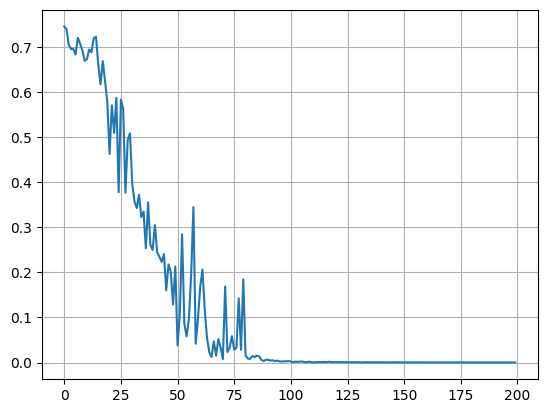

In [38]:
plt.figure()
plt.plot(range(EPOCHS), trn_losses)
plt.grid(which='major')

In [22]:
def encode(text):
    encoded_text = []
    for word in text.split():
        if word in vocab:
            encoded_text.append(vocab.index(word))
        else:
            encoded_text.append(len(vocab) + 1)
    while len(encoded_text) < max_seq:
        encoded_text.append(len(vocab))
    return torch.tensor(encoded_text)

In [39]:
encoded_text = encode("This vacuum is really bad")
output = model(encoded_text.reshape(1,-1))


In [40]:
model.eval()
correct = 0
for input_seqs, labels in test_loader:
    pred_labels = model(input_seqs)
    pred_labels = pred_labels.argmax(axis=1)
    correct += (pred_labels == labels).sum().item()
print(f"Test accuracy: {correct*100/len(test_loader.dataset):>.2f}%")

Test accuracy: 54.00%


In [33]:
print('-'*50)
user_input = input()
while user_input != '':
    print(user_input)
    encoded_text = encode(user_input)
    output = model(encoded_text.reshape(1,-1))
    print(f"The user input is {'NEGATIVE' if output.argmax().item() == 0 else 'POSITIVE'}")
    print('-'*50)
    user_input = input()

--------------------------------------------------
I did not like this product
The user input is NEGATIVE
--------------------------------------------------
I really liked it!
The user input is POSITIVE
--------------------------------------------------


In [2]:
from keras import layers
import numpy as np

In [13]:
x = layers.UpSampling2D(size=(2,2))
example_tensor = np.array(([[[[1,2],
                            [3,4]]]]))
x(example_tensor.reshape((2,2,1,1))).shape

TensorShape([2, 4, 2, 1])